In [1]:
import ai2thor
from ai2thor.controller import Controller
from ai2thor.platform import CloudRendering
from tools.vis_tool import *
from tools.transform import cornerpoint_projection
from tools.map import single_scenemap
from tools.astar import astar
import random
import math

"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 4.2.0'

In [2]:
controller = Controller()


In [3]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)


<ai2thor.server.Event at 0x7fe600aad610
    .metadata["lastAction"] = Initialize
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}
>

In [4]:
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=2.5, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize=3.25,
    skyboxColor="white"
)

<ai2thor.server.Event at 0x7fe600a78fd0
    .metadata["lastAction"] = AddThirdPartyCamera
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [5]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
print(scene_bounds)

[[1.5, 3.200000286102295], [1.5, -2.799999713897705], [-4.400001049041748, 3.200000286102295], [-4.400001049041748, -2.799999713897705]]


In [6]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']


In [16]:

controller.step(
    action="Teleport",
    position=dict(x=rstate[20]['x'], y=0.9, z=rstate[20]['z'])
)
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]

-4.400001049041748 1.5 -2.799999713897705 3.200000286102295
-4.25 1.5 -2.75 3.0
(24, 24)


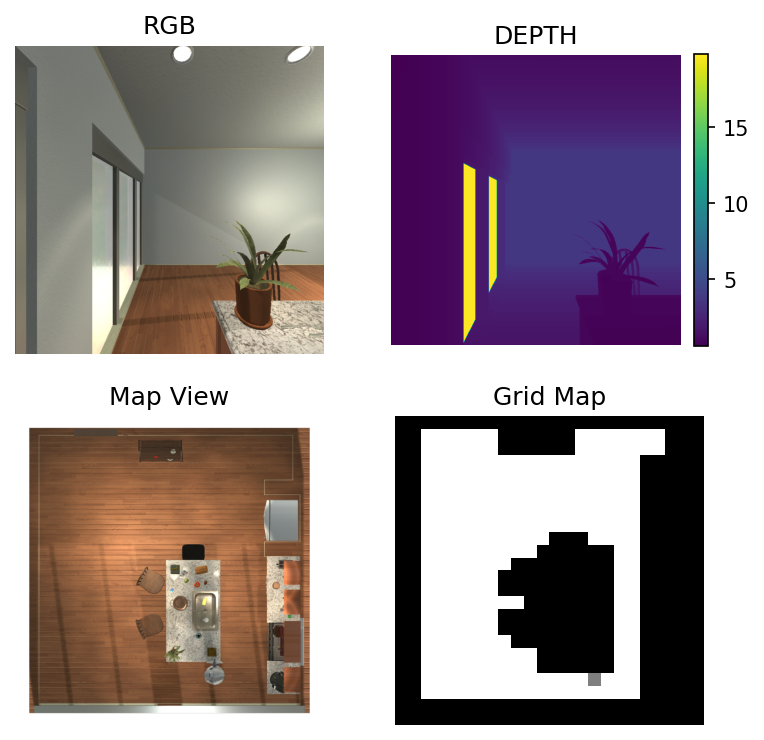

In [17]:
sm = single_scenemap(scene_bounds,rstate)
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)


In [10]:
goal = random.choice(rstate)
goal = [goal['x'],goal['z']]
print(goal)

[-3.25, 2.75]


In [11]:
cpos= sm.gridmap_pos(pos)
goal = sm.gridmap_pos(goal)
print(cpos,goal)
path = astar(sm.grid_map,goal,cpos)

[15, 3] [4, 22]
Done


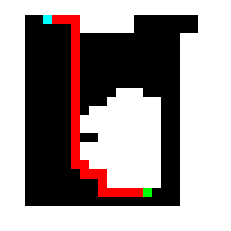

In [12]:
def show_path(path,gridmap):
    gridmap_rgb = np.expand_dims(gridmap,-1)
    gridmap_rgb = np.repeat(gridmap_rgb,3,-1)
    for p in path[1:-1]:
        gridmap_rgb[p[0],p[1],:] = [1,0,0]
    init = path[0]
    end = path[-1]
    gridmap_rgb[init[0],init[1],:] = [0,1,0]
    gridmap_rgb[end[0],end[1],:] = [0,1,1]
    gridmap_rgb = np.rot90(gridmap_rgb)
    plt.axis('off')
    plt.imshow(gridmap_rgb)
    
show_path(path,sm.grid_map)
e=0

In [13]:
for e in range(len(path)-1):

    dx = path[e+1][0] - path[e][0]
    dy = path[e+1][1] - path[e][1]
    trot = math.atan2(dx,dy)*180/math.pi
    crot = controller.last_event.metadata['agent']['rotation']['y'] 
    rot = trot - crot
    controller.step(
        action="RotateRight",
        degrees=rot
    )

    controller.step(
        action="MoveAhead",
        moveMagnitude=None
    )

[-3.25, 2.75]


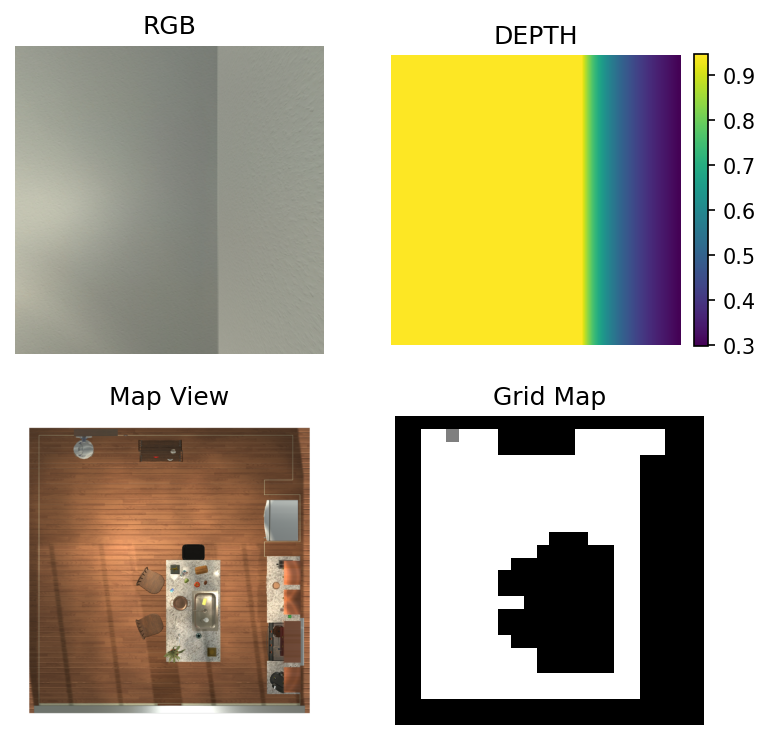

In [14]:
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
print(pos)
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)